In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

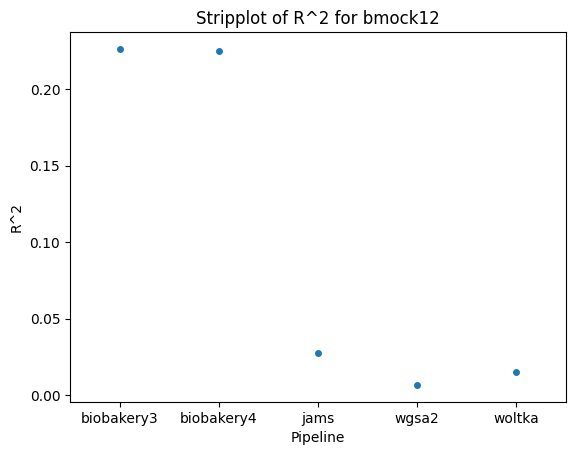

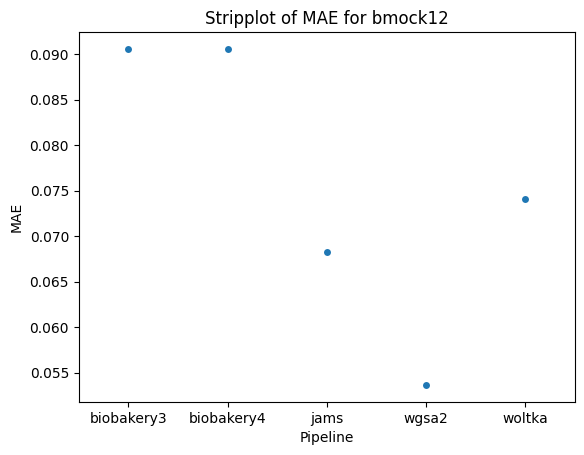

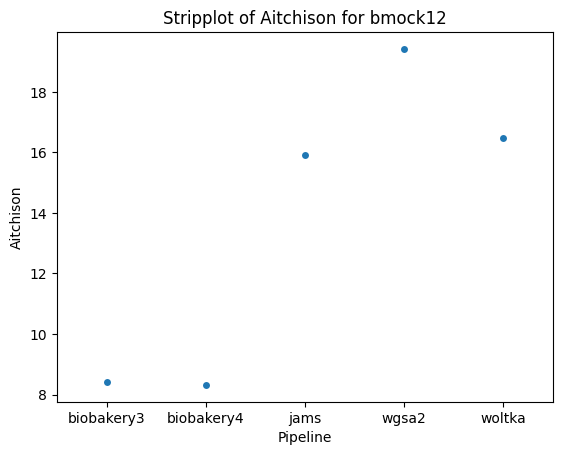

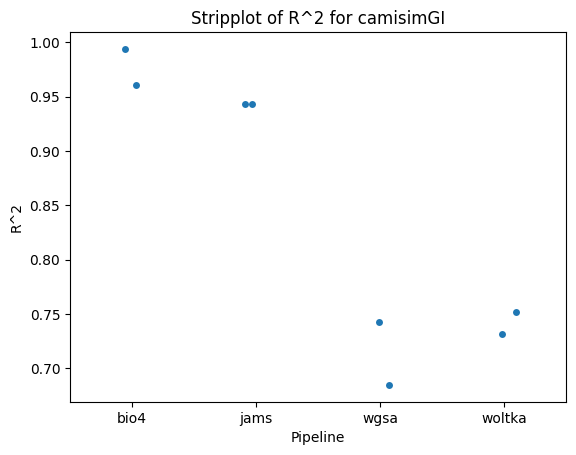

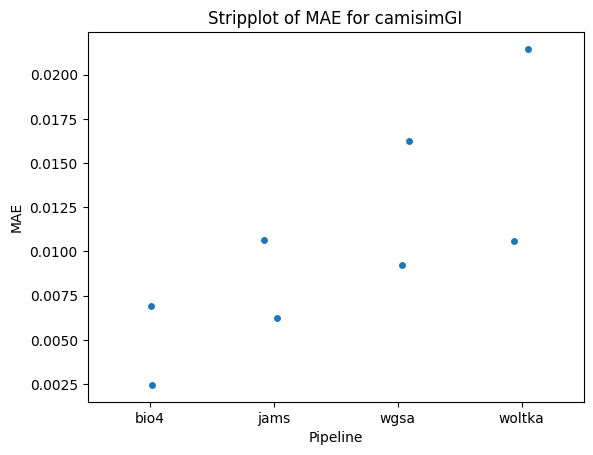

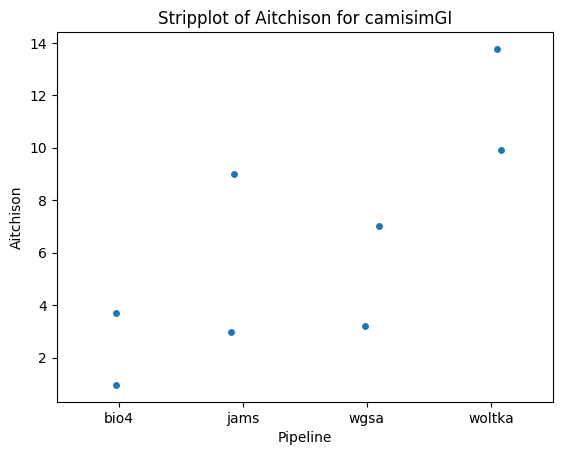

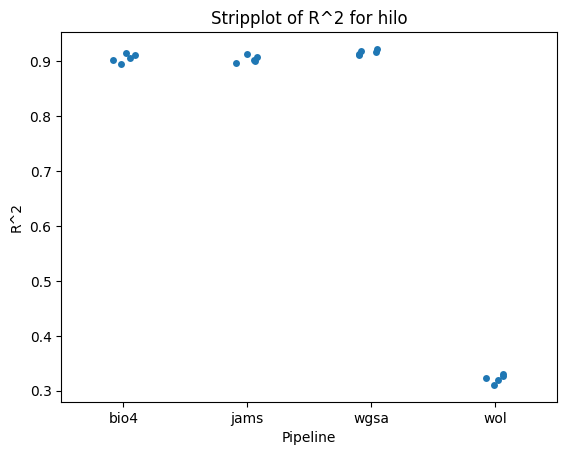

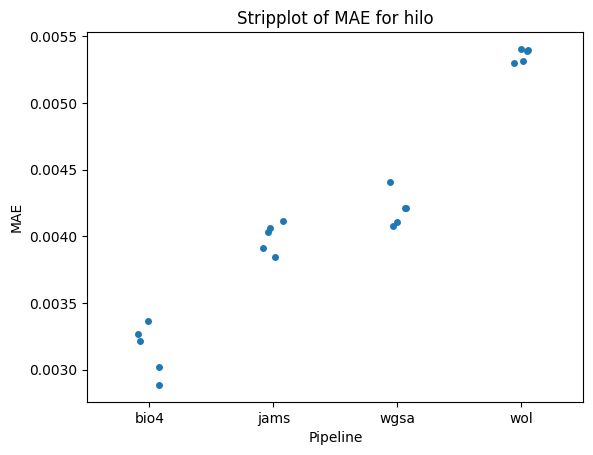

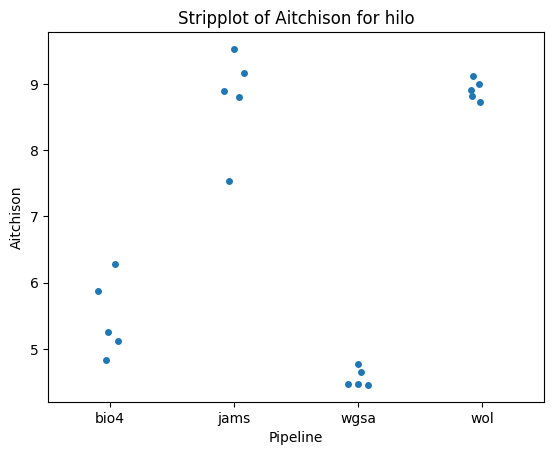

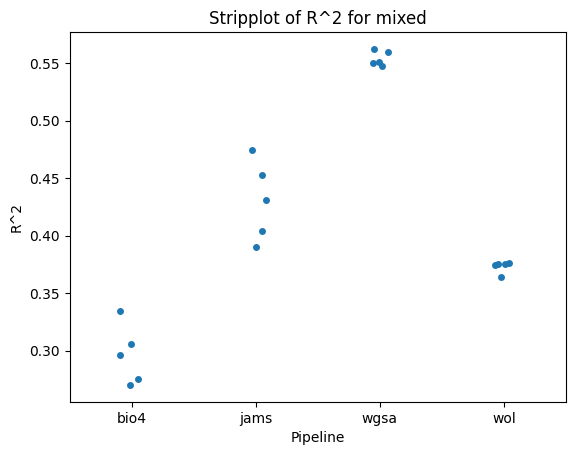

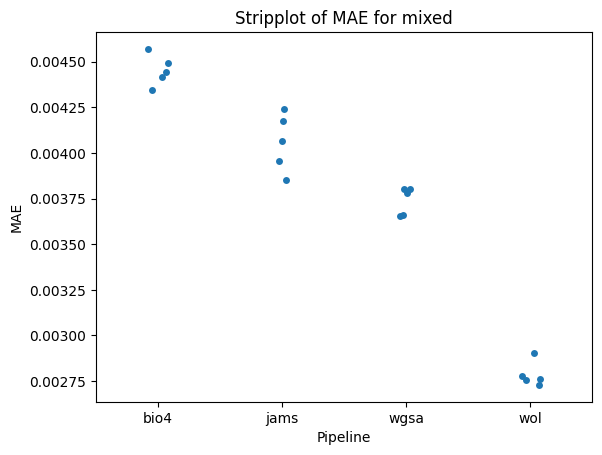

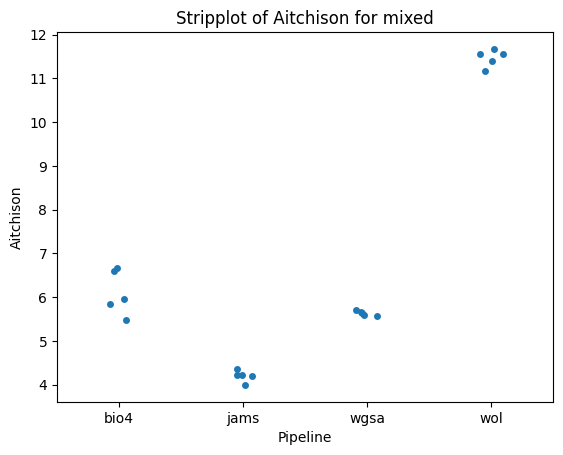

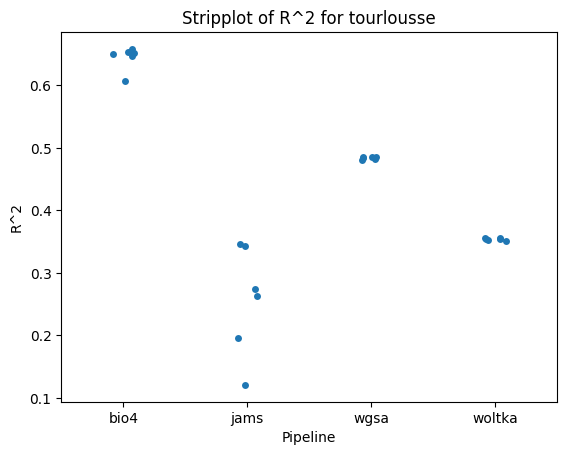

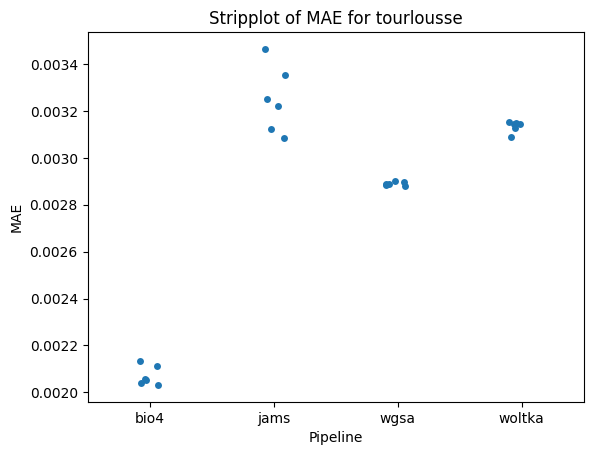

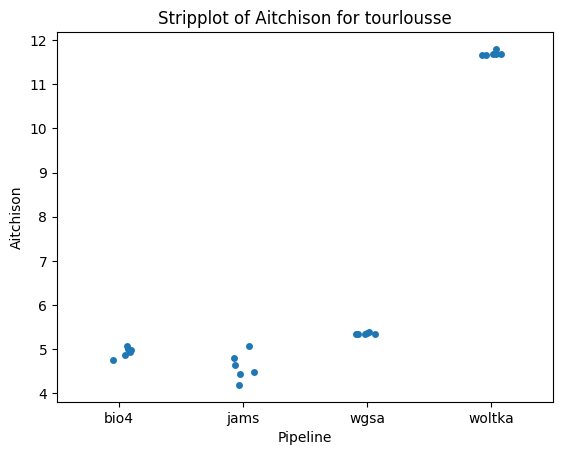

,SampleID,R^2,MAE,Aitchison,Pipeline,Source
0,SRR11487937,0.274986,0.004570,5.970235,bio4,mixed
1,SRR11487938,0.334939,0.004419,5.469377,bio4,mixed
2,SRR11487939,0.270239,0.004492,6.659167,bio4,mixed
3,SRR11487940,0.296280,0.004343,5.836459,bio4,mixed
4,SRR11487941,0.306064,0.004444,6.590351,bio4,mixed


In [5]:
project_root = os.path.abspath("../../pipelines/")
threshold = 0.0001

# First, we load the data from the CSV file.
def find_stats_files():
    for root, dirs, files in os.walk(project_root):
        for file in files:
            # print(file)
            if "stats" in file and file.endswith('.csv'):
                stats_path = os.path.join(root, file)
                df = pd.read_csv(stats_path)
                yield stats_path, df

combined_df = pd.DataFrame()

for path, df in find_stats_files():
        df["Source"] = path.split("/")[-2]
        combined_df = pd.concat([combined_df, df])


for src, df in combined_df.groupby("Source"):
    plots = ["R^2", "MAE", "Aitchison"]
    for p in plots:
        ax = sns.stripplot(data=df, x="Pipeline", y=p)
        ax.set_title("Stripplot of {} for {}".format(p, src))
        plt.show()


combined_df.to_csv(f"all_stats_{str(threshold)}.csv", index=False)
display(combined_df.head())